## Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%config InlineBackend.figure_format = 'png'
import xgboost as xgb

In [3]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')

In [4]:
train.shape

(1460, 81)

In [5]:
test.shape

(1459, 80)

In [6]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))

In [8]:
all_data.shape

(2919, 79)

## Preprocessing

#### Make skewed numeric features log(feature + 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb0c56a42d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb0c31f4450>]], dtype=object)

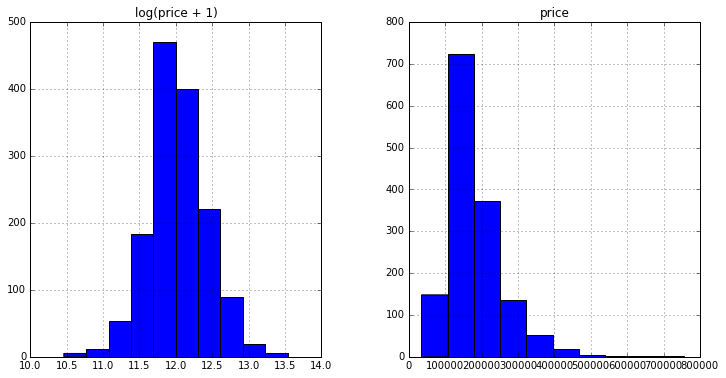

In [9]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({'price': train['SalePrice'], 'log(price + 1)': np.log1p(train['SalePrice'])})
prices.hist()

In [10]:
# Transform the target value to log
train['SalePrice'] = np.log1p(train['SalePrice'])
# Extract numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewness_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #Compute skewness
skewed_feats = skewness_feats[skewness_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
# Get dummy variables
all_data = pd.get_dummies(all_data)

In [12]:
all_data.shape

(2919, 288)

## Fill NAs 

In [13]:
# Fill NAs with the mean of each column (maybe to improve)
all_data = all_data.fillna(all_data.mean())

### Creating the dataset 

In [14]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

pandas.core.series.Series

### Model construction

In [192]:
# Imports
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLars
from sklearn import cross_validation

def rmse_cv(model):
    rmse = np.sqrt(-cross_validation.cross_val_score(model, X_train, y, scoring='mean_squared_error'))
    return rmse

#### Ridge regression

In [193]:
model_ridge = Ridge()

In [199]:
## Applying cross validation to alpha
alphas = [0.05, 0.1, 0.3, 0.5, 0.8, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

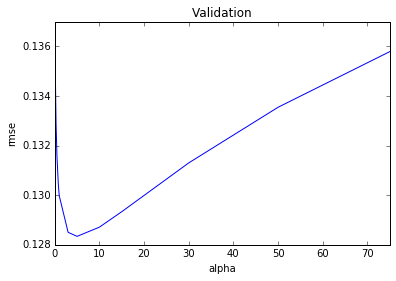

In [200]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title= "Validation")
plt.xlabel('alpha')
plt.ylabel('rmse')

In [202]:
# the good alpha is approx 5
cv_ridge.min()

0.1283404328800907

#### Lasso Regression

In [203]:
model_lasso = LassoCV(alphas = [0.0005, 0.001, 0.1, 1]).fit(X_train, y)

In [204]:
rmse_cv(model_lasso).mean()

0.12472239832501379

0.00050000000000000001

In [206]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [207]:
print('Lasso picked ' + str(sum(coef!=0)) + ' variables and eliminated the others ' + str(sum(coef == 0)) + ' variables')

Lasso picked 110 variables and eliminated the others 178 variables


#### Checking features importances

In [208]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

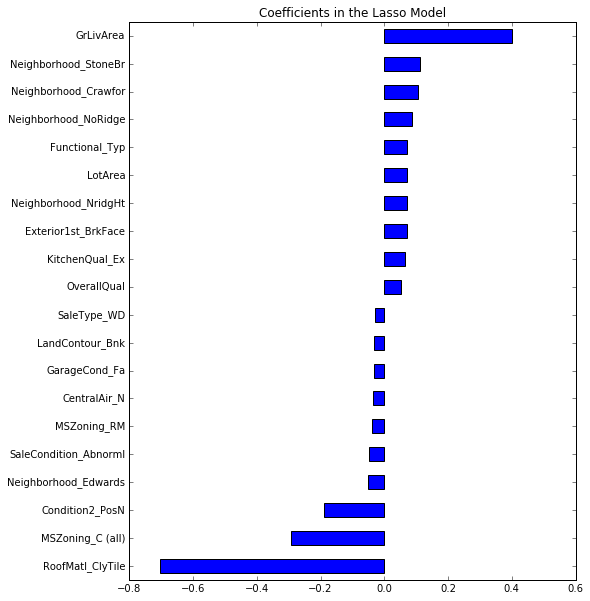

In [212]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh')
plt.title("Coefficients in the Lasso Model")

In [217]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [218]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

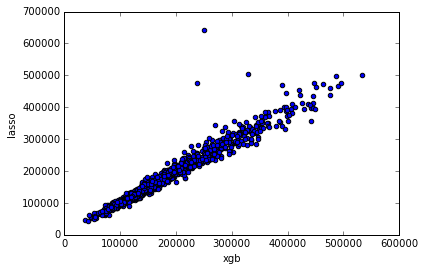

In [219]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")

In [ ]:
preds = 0.7*lasso_preds + 0.3*xgb_preds